Proyecto de Series Temporales

         Objetivo: Estimar el número de ventas.

In [26]:
#!pip install missingno lazypredict
!pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 61.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 9.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from statsmodels.tsa.stattools import adfuller


1. Carga del conjunto de datos.

In [4]:
# Descargo los datos base datos "sales":

# Leo los datos de la URL.
url = "https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv"

# Guardo los datos en un DataFrame. La BD tiene 366 filas y 2 columnas.
df = pd.read_csv(url)

# Miro las variables de la bd.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [23]:
df.head()
df.tail()

,date,sales
361,2023-08-30 17:10:08.079328,989.600354
362,2023-08-31 17:10:08.079328,994.987326
363,2023-09-01 17:10:08.079328,995.814415
364,2023-09-02 17:10:08.079328,997.350214
365,2023-09-03 17:10:08.079328,1000.482785


2. Construye y analiza la serie temporal.

In [6]:
df.dtypes

date      object
sales    float64
dtype: object

In [8]:
df.isna().sum()

date     0
sales    0
dtype: int64

In [7]:
df.duplicated().sum()

np.int64(0)

No hay valores duplicados.

In [11]:
df.Date = pd.to_datetime(df.date)
df.dtypes

/tmp/ipykernel_5351/3175655761.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.Date = pd.to_datetime(df.date)


date      object
sales    float64
dtype: object

In [16]:
df.date.max()

'2023-09-03 17:10:08.079328'

In [17]:
df.date.min()

'2022-09-03 17:10:08.079328'

In [12]:
(df.Date.max()-df.Date.min()).days

365

Hay 365 días 

In [13]:
df.date.nunique()

366

No hay valores faltantes en las fechas.

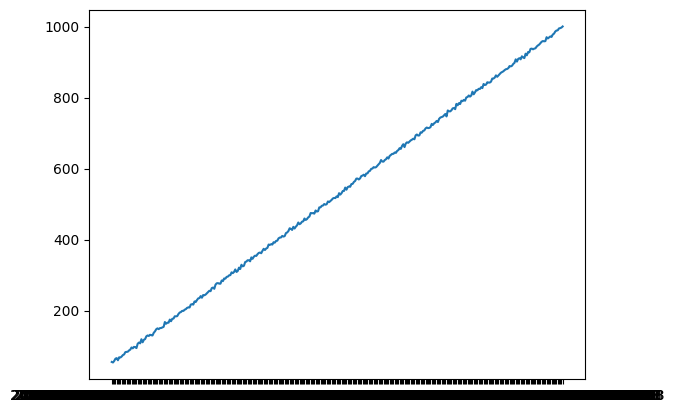

In [21]:
# Gráfico serie temporal
plt.plot(df.date, df.sales)

In [32]:
# Descomponer la serie temporal.
decomposition = seasonal_decompose(df.sales, period = 12)
decomposition


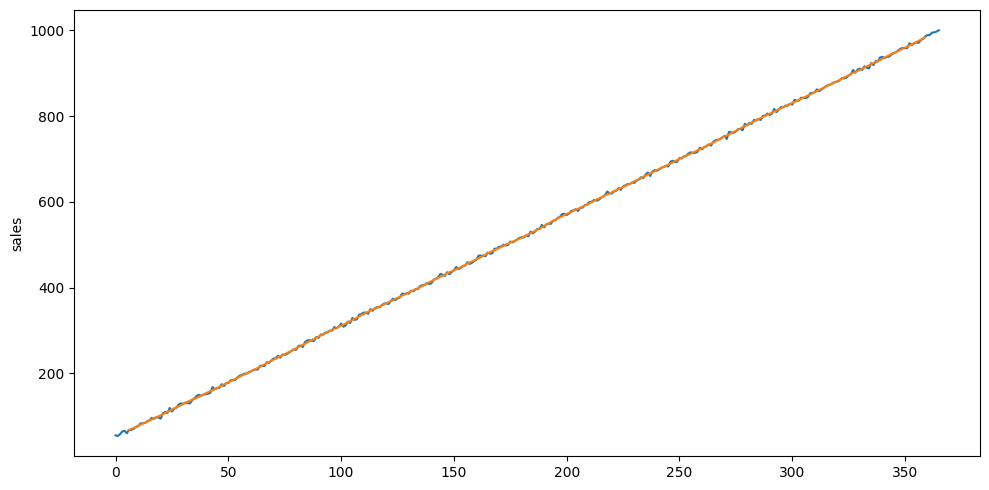

In [35]:
# Tendencia.
trend = decomposition.trend

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = df.sales)
sns.lineplot(data = trend)

plt.tight_layout()

plt.show()

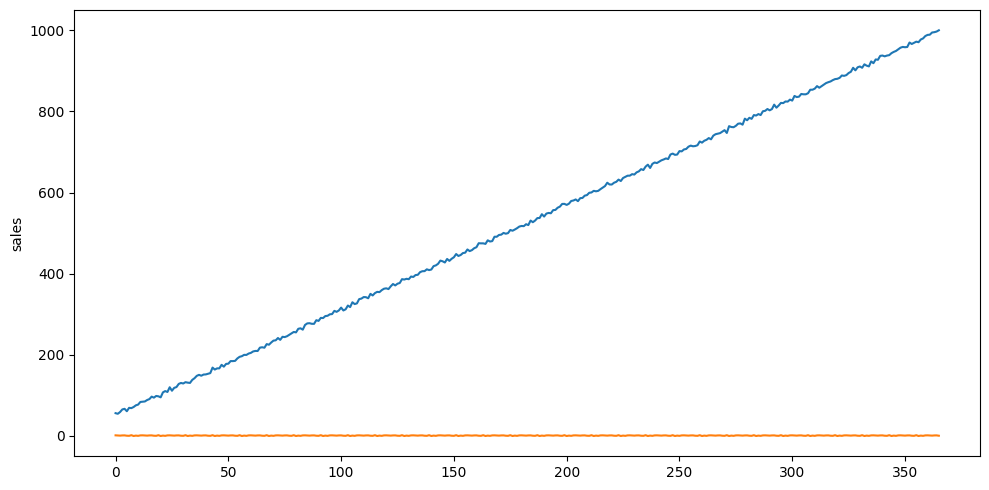

In [36]:
# Estacionalidad.
seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = df.sales)
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

In [38]:
def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(df.sales)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

No podemos rechazar la H0. Por lo tanto, la serie es estacionaria.

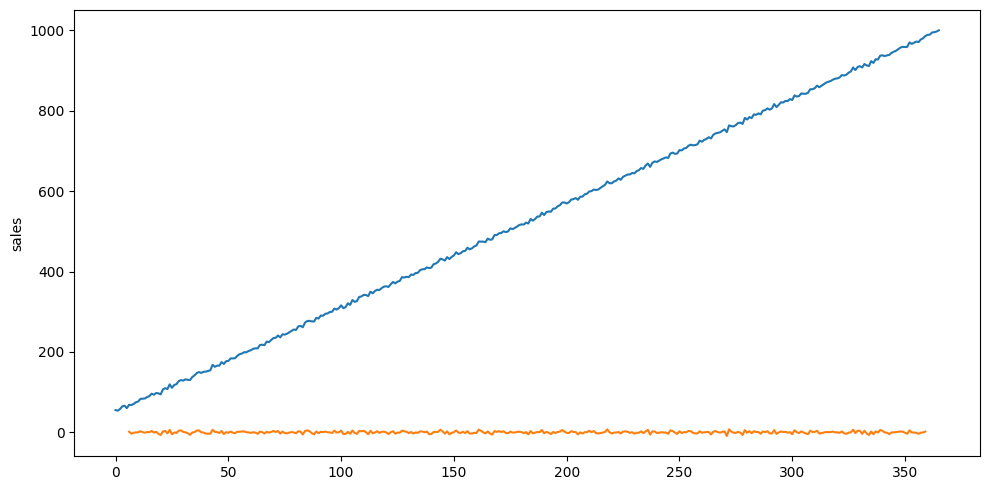

In [39]:
# Análisis variabilidad.
residual = decomposition.resid

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = df.sales)
sns.lineplot(data = residual)

plt.tight_layout()

plt.show()